In [13]:
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import urllib.request
from urllib.error import HTTPError

from SGA import SGA

## Zadanie 5.
Wykorzystaj zaimplementowane algorytmy do rozwiązywania problemu Q3AP. Użyj (odpowiednio przekształconych – patrz notatka o problemach QAP i Q3AP) danych testowych z biblioteki QAPLIB. Przeprowadź obliczenia co najmniej dla następujących zestawów danych: Nug12, ... Nug30. Przeanalizuj działanie algorytmu i otrzymane wyniki.

Najlepsze znane mi rozwiązania problemu Q3AP dla wyżej wymienionych testowych zestawów danych to:
- Nug8: 134 (znajdowane po średnio 1s obliczeń) 
- Nug10: 430 (znajdowane po średnio 5s obliczeń) 
- Nug12: 580 (znajdowane po średnio 90s obliczeń) 
- Nug13: 1912 (znajdowane po średnio 732s obliczeń) 
- Nug14: 2320 (znajdowane po średnio 764s obliczeń) 
- Nug15: 2230 (znajdowane po średnio 2032s obliczeń) 
- Nug20: 7750 (znalezione po ok. 12h obliczeń)
- Nug30: 28706 (znalezione po ok. 12h obliczeń)

In [14]:
def get_nug(nug):
    instance_url = f'http://anjos.mgi.polymtl.ca/qaplib/data.d/nug{nug}.dat'
    
    qap_instance_file = urllib.request.urlopen(instance_url)
    
    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])

    A = np.empty((n, n))
    
    qap_instance_file.readline()
    
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))

    B = np.empty((n, n))
    qap_instance_file.readline()
    
    for i in range(n):
        line = qap_instance_file.readline()
        if nug == 30:
            line += qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    
    return n, A, B

#### Rather than keeping 2 permutations p and q let's keep $p_0...p_{n-1}q_0...q_{n-1}$

In [64]:
def qap_objective_function(perm, n, flow, dists):
    p, q = np.split(perm, 2)
    
    s = 0.0
    for i in range(n**2):
        for j in range(n**2):
            s += flow[p[i]][p[j]] * flow[q[i]][q[j]] * dists[i][j]**2
    return s

In [18]:
def objective_func(perm, dists):
    return qap_objective_function(perm, n, flow, dists)

In [25]:
def PMX(ind1, ind2, separator_no=2):
    new_ind1, new_ind2 = ind1.copy(), ind2.copy()
    p1, q1 = np.split(new_ind1, 2)
    p2, q2 = np.split(new_ind2, 2)
    
    idxs = sorted(np.random.choice(len(p1), separator_no, replace=False))
    
    group = np.random.choice(separator_no-1)
    start, end = idxs[group], idxs[group+1]
    
    tmp = p1[start:end].copy()
    p1[start:end] = p2[start:end]
    p2[start:end] = p1[start:end]
    
    tmp = q1[start:end].copy()
    q1[start:end] = q2[start:end]
    q2[start:end] = q1[start:end]
    
    for i in range(len(p1)):
        if start <= i < end:
            continue
        
        while p1[i] in p1[start:end]:
            # get elem from the other ind
            idx_of_elem = np.nonzero(p1[start:end] == p1[i])[0][0]
            p1[i] = p2[start+idx_of_elem]
            q1[i] = q2[start+idx_of_elem]
        
        while p2[i] in p2[start:end]:
            # get elem from the other ind
            idx_of_elem = np.nonzero(p2[start:end] == p2[i])[0][0]
            p2[i] = p1[start+idx_of_elem]
            q2[i] = q1[start+idx_of_elem]

    ind1 = np.append(p1, q1)
    ind2 = np.append(p2, q2)
    return ind1, ind2

In [20]:
def reverse_sequence_mutation(og_perm, *args):
    i, j = sorted(np.random.choice(len(og_perm), 2, False))
    perm = og_perm.copy()
    p, q = np.split(perm, 2)
    
    p[i:j] = p[j:i:-1]
    q[i:j] = q[j:i:-1]
    
    perm = np.append(p, q)
    return perm

In [66]:
def generate_population(chromosome_length, population_size):
    current_population = [np.append(np.random.permutation(arr), np.random.permutation(arr))
                         for _ in range(population_size)]
    return current_population.astype(int)

In [67]:
n, flow, dists = get_nug(12)

sga = SGA(population_size=500, number_of_offspring=500, chromosome_length=n, 
          crossover_func=PMX, mutation_func=reverse_sequence_mutation, objective_func=objective_func,
          generate_population_func=generate_population,
         distance_matrix=dists, number_of_iterations=100)

sga.run(with_tqdm=True)

NameError: name 'arr' is not defined

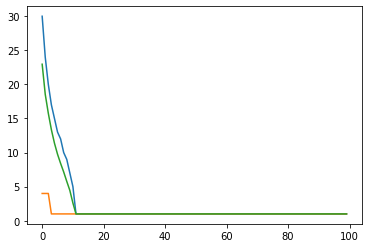

In [16]:
sga.plot_costs()